In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
os.chdir(os.path.join('..','data'))
df = pd.read_csv(r'2002FemPreg.csv',low_memory=False)
df = df[['caseid','prglngth','outcome','pregordr','birthord','totalwgt_lb','agepreg','finalwgt']]
df_live = df[df['outcome']==1]
# removing null values
df = df_live[df_live['totalwgt_lb'].notnull()]

In [3]:
df.head()

,caseid,prglngth,outcome,pregordr,birthord,totalwgt_lb,agepreg,finalwgt
0,1,39,1,1,1.0,8.8125,33.16,6448.271112
1,1,39,1,2,2.0,7.8750,39.25,6448.271112
2,2,39,1,1,1.0,9.1250,14.33,12999.542260
3,2,39,1,2,2.0,7.0000,17.83,12999.542260
4,2,39,1,3,3.0,6.1875,18.33,12999.542260


In [5]:
def jitter_data(values,level=0.5):
    return np.random.uniform(-level,level,len(values)) + values

Text(0.5,1,'Jittered data')

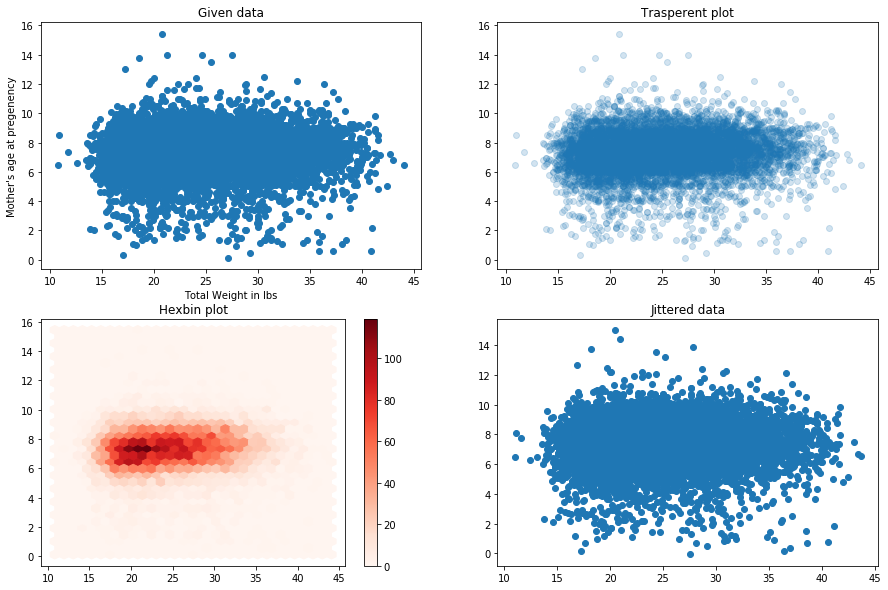

In [30]:
X = df.agepreg
Y = df.totalwgt_lb

# subplot(nrows, ncols, index, **kwargs)
fig = plt.figure()
fig.set_size_inches(15,10)

# add a automated to plot n by n number of subplots with titles and axis labels

# Normal scatter plot
ax1 = plt.subplot(221)
ax1.scatter(X,Y)
ax1.set_title('Given data')
ax1.set_xlabel('Total Weight in lbs')
ax1.set_ylabel('Mother\'s age at pregenency')

# Transperent plot
ax2 = plt.subplot(222)
ax2.scatter(X,Y,alpha=0.2)
ax2.set_title('Trasperent plot')

# Hexbin plot
ax3 = plt.subplot(223)
fig.colorbar(ax3.hexbin(X,Y,gridsize=30,cmap=plt.cm.Reds))
ax3.set_title('Hexbin plot')

# Jitter plot - adding random noise
height_jitter = jitter_data(X,level=0.5)
wgt_jitter = jitter_data(Y,level=0.5)

ax4 = plt.subplot(224)
ax4.scatter(height_jitter,wgt_jitter)
ax4.set_title('Jittered data')

In [63]:
# percentile of birth weights vs age of mother at time of pregnency
def eval_cdf(value,series):
    count =0
    for x in series:
        if x <= value:
            count += 1
    return count/len(series)

def compute_cdf(series):
    x = sorted(list(series))
    y = []
    for value in x:
        y.append(eval_cdf(value,x))
    return x,y

def pearson_coeff (x,y):
    x = np.asarray(x)
    y = np.asarray(y)
    
    xmean = np.mean(x)
    ymean = np.mean(y)
    std_x = np.std(x)
    std_y = np.std(y)
    
    xi = [(val-xmean)/std_x for val in x] 
    yi = [(val-ymean)/std_y for val in y]
    
    return sum(xi*np.transpose(yi))/len(x)
def spearman_coeff(x_series,y_series):
    rank1 = x_series.rank()
    rank2 = y_series.rank()
    return pearson_coeff(rank1,rank2)
def percentile(p,series):
    series, cdfs = compute_cdf(series)
    if p < min(cdfs):
        p = min(cdfs)
    return series[cdfs.index(max([cdf for cdf in cdfs if cdf <=p]))]

In [50]:
print('Pearson\'s coefficient:',pearson_coeff(X,Y))
print('Spearman\'s rank coefficient:',spearman_coeff(X,Y))

Pearson's coefficient: 0.06883397035410913
Spearman's rank coefficient: 0.09461004109658225


The correlations support this.  Pearson's is around 0.07, Spearman's
is around 0.09.  

The difference between them suggests some influence of **outliers or a non-linear relationsip**.

characterizing the relationship
- bin the age and find the percentile of the weights in each bins
- plot the 25th,50th and 75th percentile plots

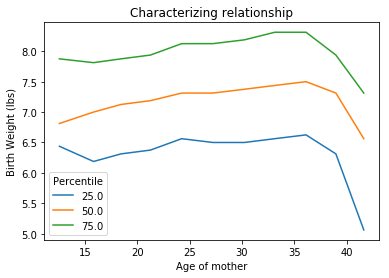

In [72]:
bins = np.arange(min(X),max(X)-1,3)
indices = np.digitize(df['agepreg'],bins)
groups = df.groupby(indices)

age = [np.mean(group['agepreg']) for i,group in groups]
for p in [0.25,0.5,0.75]:
    cdf_wgts = [percentile(p,group['totalwgt_lb']) for i,group in groups]  
    plt.plot(age,cdf_wgts,label=str(p*100))

plt.title('Characterizing relationship')
plt.xlabel('Age of mother')
plt.ylabel('Birth Weight (lbs)')
plt.legend(title='Percentile')

Plotting percentiles of weight versus age suggests that the
  relationship is non-linear.  Birth weight increases more quickly
 in the range of mother's age from 15 to 25.  After that, the effect
 is weaker.